# Proyecto 1 – Atención de Incidentes  
## Tarea 4 – Modelamiento

Exploración de diferentes configuraciones de modelo, realizar ingeniería de características, emplear diferentes métodos de estimación, comparar y seleccionar las mejores
alternativas.

Empecemos importando numpy y pandas

In [104]:
import numpy as np
import pandas as pd

Carguemos el archivo incident_event_log.csv usando pandas.

In [105]:
df = pd.read_csv("incident_event_log.csv")
df = df.replace('?', np.nan)
df.shape

(141712, 36)

In [106]:
df.isna().sum()

number                          0
incident_state                  0
active                          0
reassignment_count              0
reopen_count                    0
sys_mod_count                   0
made_sla                        0
caller_id                      29
opened_by                    4835
opened_at                       0
sys_created_by              53076
sys_created_at              53076
sys_updated_by                  0
sys_updated_at                  0
contact_type                    0
location                       76
category                       78
subcategory                   111
u_symptom                   32964
cmdb_ci                    141267
impact                          0
urgency                         0
priority                        0
assignment_group            14213
assigned_to                 27496
knowledge                       0
u_priority_confirmation         0
notify                          0
problem_id                 139417
rfc           

In [107]:
# Eliminar filas donde resolved_at es NaN
df = df.dropna(subset=['resolved_at'])
df.shape

(138571, 36)

Ahora construyamos un DataFrame con la información que vamos a requerir para la construcción del modelo.

In [108]:
# Primero, convertir las columnas de fecha a tipo datetime.
df['opened_at'] = pd.to_datetime(df['opened_at'], errors='coerce')
df['resolved_at'] = pd.to_datetime(df['resolved_at'], errors='coerce')


/var/folders/zd/p45fwfgs5vn1bfkb1kqzmytw0000gn/T/ipykernel_77122/2346255548.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['opened_at'] = pd.to_datetime(df['opened_at'], errors='coerce')
/var/folders/zd/p45fwfgs5vn1bfkb1kqzmytw0000gn/T/ipykernel_77122/2346255548.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['resolved_at'] = pd.to_datetime(df['resolved_at'], errors='coerce')


In [109]:
df_modelo = pd.DataFrame()
df_modelo['time_to_resolve'] = (df['resolved_at'] - df['opened_at']).dt.total_seconds() / 3600.0
df_modelo['reassignment_count'] = df['reassignment_count']
df_modelo['sys_mod_count'] = df['sys_mod_count']
df_modelo['reopen_count'] = df['reopen_count']

Codifiquemos la variable categórica Origin

In [110]:
priority_dummies = pd.get_dummies(df['priority'], prefix='priority',dtype=int)
df_modelo = pd.concat([df_modelo, priority_dummies], axis=1)

In [111]:
df_modelo.head()

,time_to_resolve,reassignment_count,sys_mod_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low
0,10.216667,0,0,0,0,0,1,0
1,10.216667,0,2,0,0,0,1,0
2,10.216667,0,3,0,0,0,1,0
3,10.216667,0,4,0,0,0,1,0
4,29.200000,0,0,0,0,0,1,0


Separamos los datos en entrenamiento y prueba

In [112]:
train = df_modelo.sample(frac=0.8, random_state=100)
train.head()

,time_to_resolve,reassignment_count,sys_mod_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low
7214,151.033333,0,7,0,0,0,0,1
115415,46.016667,3,6,0,0,0,1,0
114165,0.333333,0,2,0,0,0,1,0
1546,364.283333,1,12,0,0,0,1,0
140332,412.050000,1,16,0,0,0,1,0


In [113]:
test = df_modelo.drop(train.index)
test.head()

,time_to_resolve,reassignment_count,sys_mod_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low
1,10.216667,0,2,0,0,0,1,0
4,29.200000,0,0,0,0,0,1,0
10,29.200000,1,6,0,0,0,1,0
11,29.200000,1,7,0,0,0,1,0
15,20.750000,0,2,0,0,0,1,0


In [114]:
print(train.shape)
print(test.shape)
print(df_modelo.shape)

(110857, 8)
(27714, 8)
(138571, 8)


Realicemos una exploración descriptiva de los datos, calculando inicialmente estadísticas de cada variable numérica

In [115]:
train.describe()

,time_to_resolve,reassignment_count,sys_mod_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low
count,110857.000000,110857.000000,110857.000000,110857.000000,110857.000000,110857.000000,110857.000000,110857.000000
mean,268.404235,1.128616,5.175063,0.022182,0.016472,0.021460,0.934375,0.027693
std,648.079899,1.750813,7.716845,0.204333,0.127281,0.144913,0.247627,0.164093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.983333,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,73.300000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,261.050000,2.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,8070.166667,27.000000,129.000000,8.000000,1.000000,1.000000,1.000000,1.000000


Exploremos relaciones bivariadas con pairplot de seaborn

In [116]:
import seaborn as sns

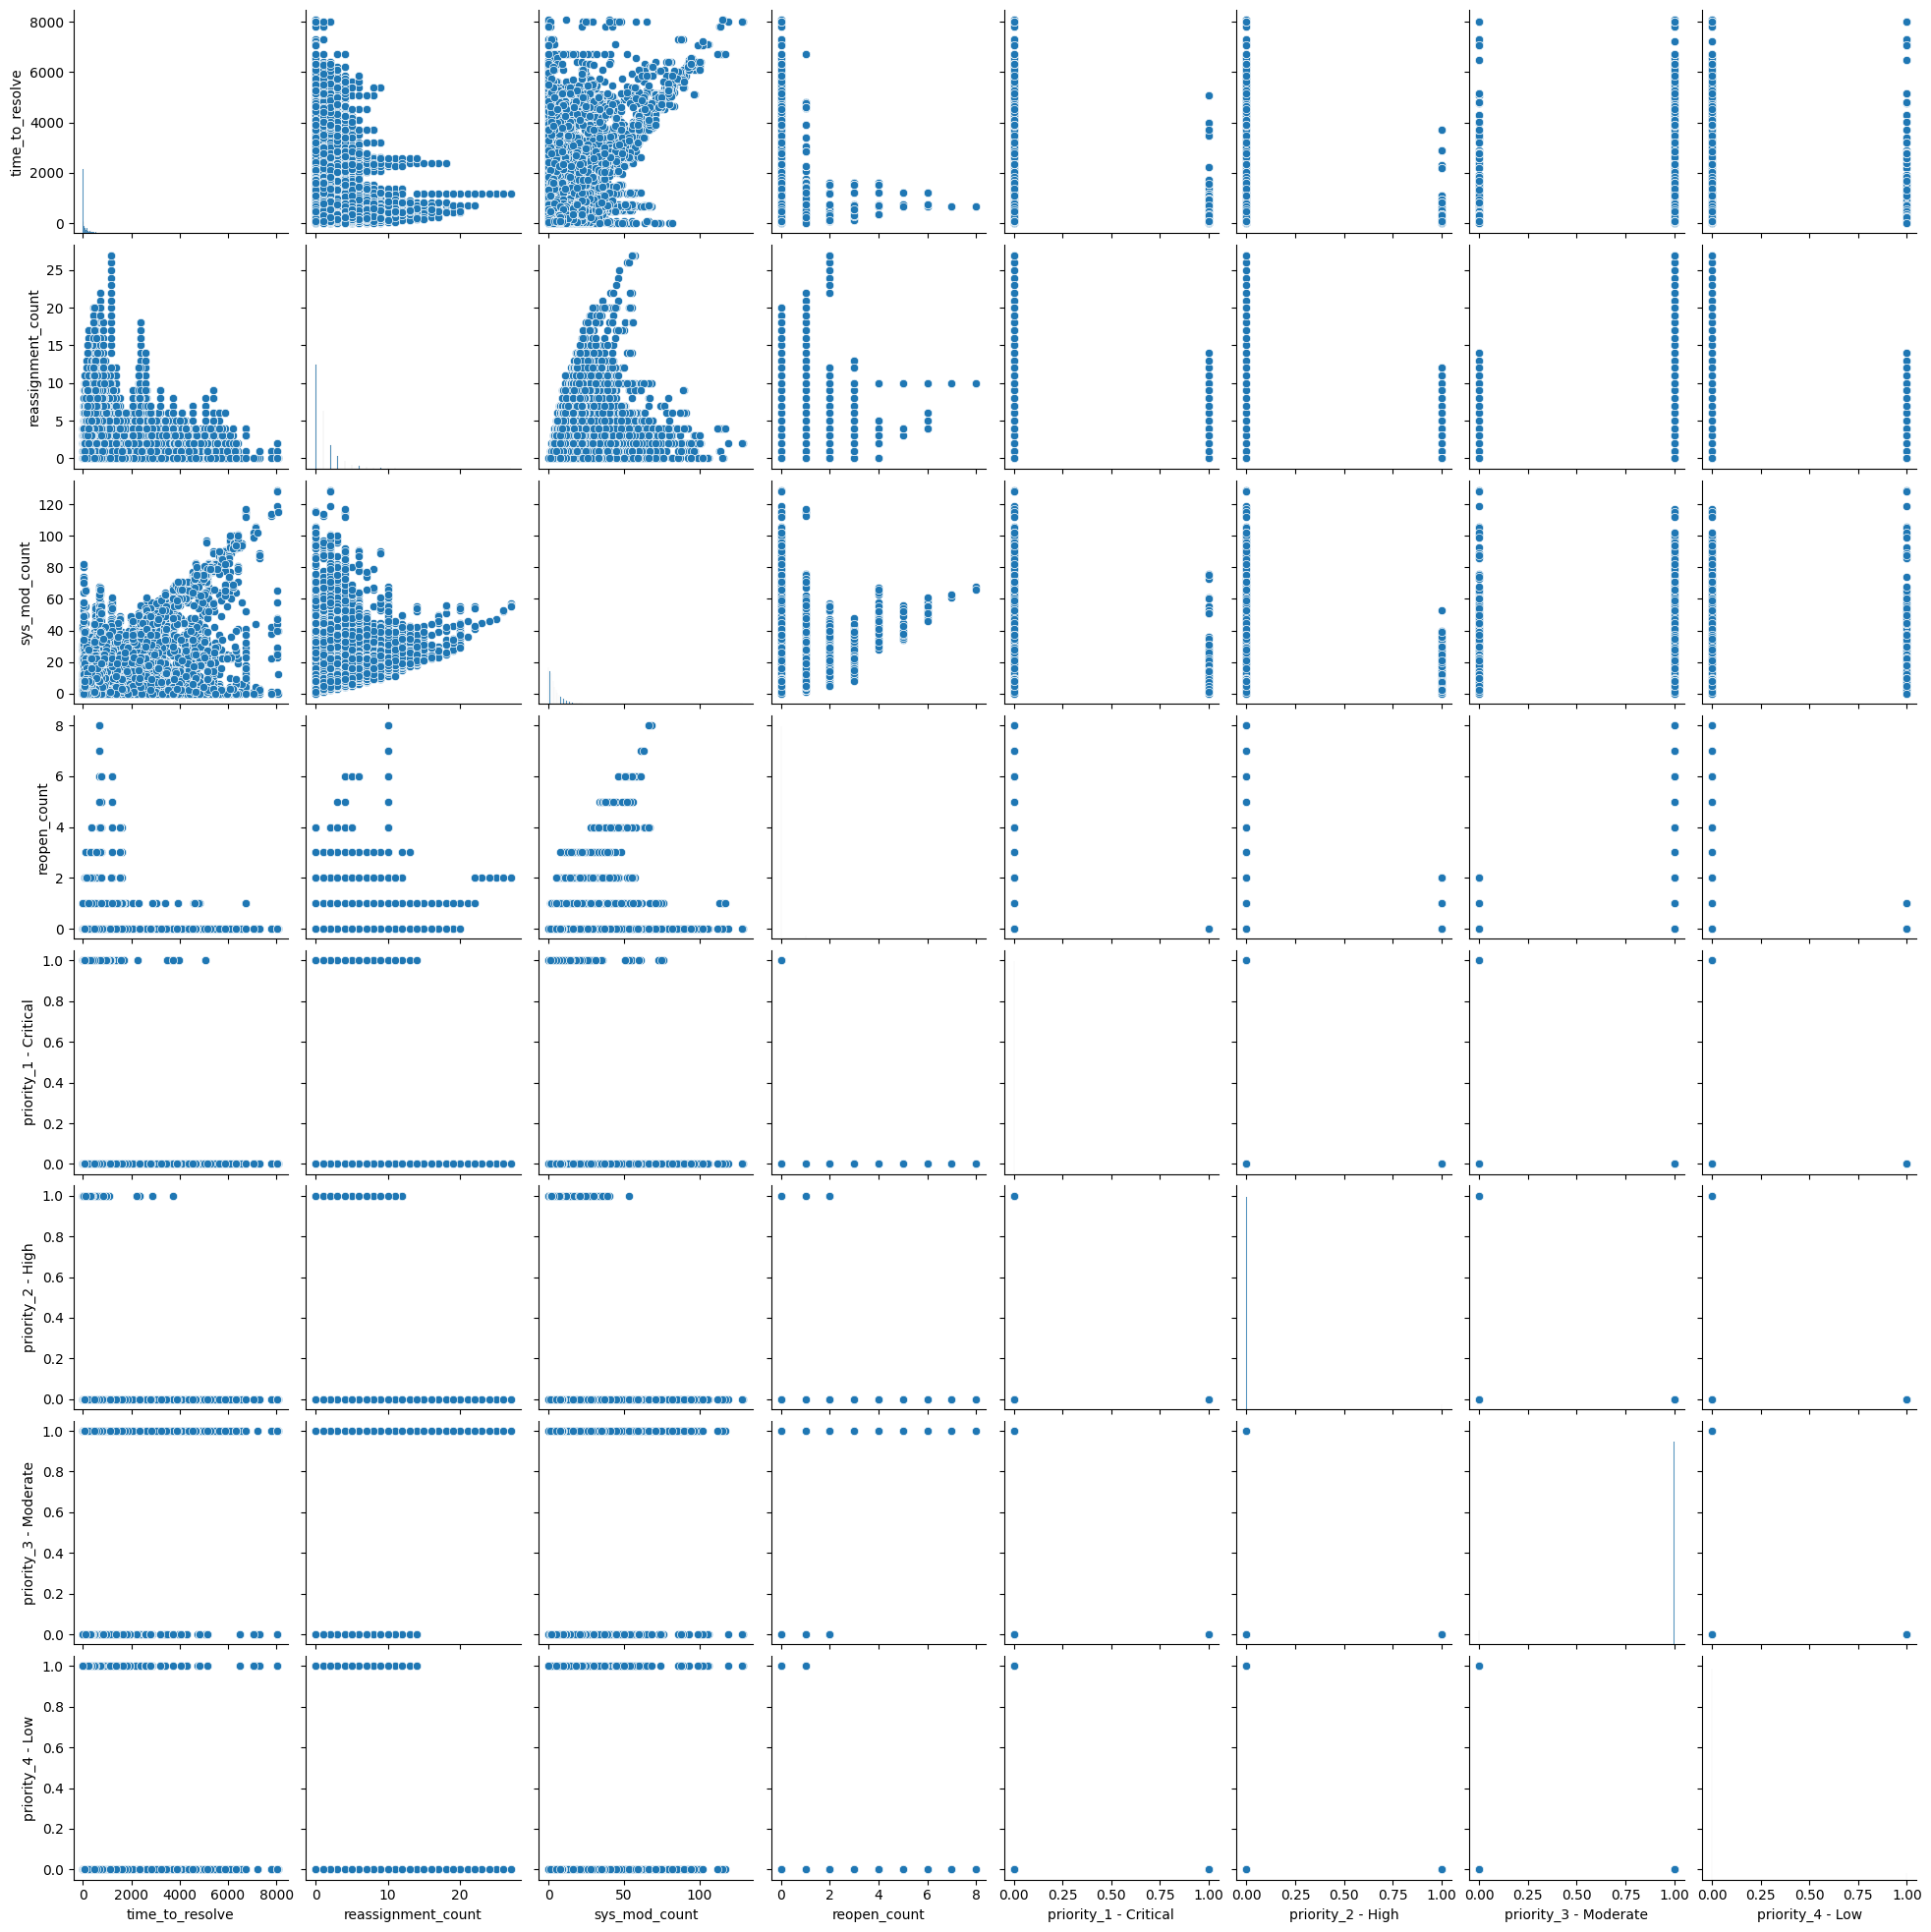

In [117]:
sns.pairplot(train)

Calculemos la matriz de correlacion

In [118]:
train.corr()

,time_to_resolve,reassignment_count,sys_mod_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low
time_to_resolve,1.000000,0.159309,0.603657,0.053473,-0.006305,-0.021324,-0.009460,0.037999
reassignment_count,0.159309,1.000000,0.523743,0.159757,0.007819,0.031146,-0.020959,-0.001942
sys_mod_count,0.603657,0.523743,1.000000,0.244891,0.025388,0.013806,-0.032084,0.016531
reopen_count,0.053473,0.159757,0.244891,1.000000,-0.014049,0.000070,0.015042,-0.011864
priority_1 - Critical,-0.006305,0.007819,0.025388,-0.014049,1.000000,-0.019165,-0.488316,-0.021840
priority_2 - High,-0.021324,0.031146,0.013806,0.000070,-0.019165,1.000000,-0.558794,-0.024993
priority_3 - Moderate,-0.009460,-0.020959,-0.032084,0.015042,-0.488316,-0.558794,1.000000,-0.636813
priority_4 - Low,0.037999,-0.001942,0.016531,-0.011864,-0.021840,-0.024993,-0.636813,1.000000


<Axes: >

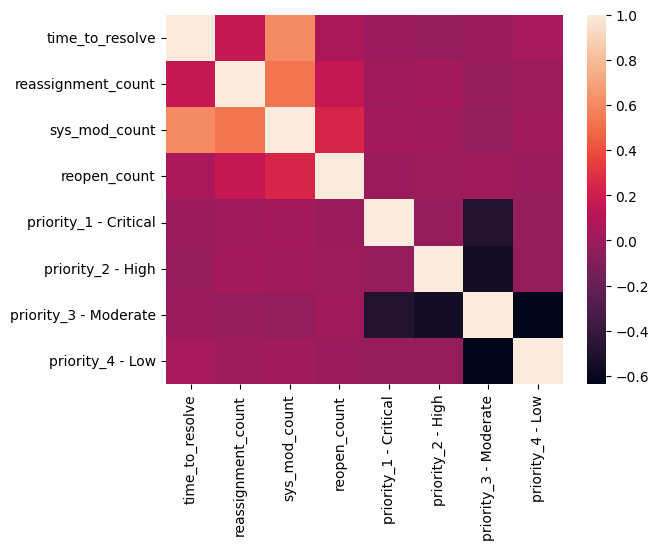

In [119]:
sns.heatmap(train.corr())

Seleccionamos ahora las características y las etiquetas (time_to_resolve)

In [120]:
train_X = train.copy()
test_X = test.copy()

In [121]:
train_y = train_X.pop('time_to_resolve')
test_y = test_X.pop('time_to_resolve')

In [122]:
train_X.head()

,reassignment_count,sys_mod_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low
7214,0,7,0,0,0,0,1
115415,3,6,0,0,0,1,0
114165,0,2,0,0,0,1,0
1546,1,12,0,0,0,1,0
140332,1,16,0,0,0,1,0


In [123]:
train_y.head()

7214      151.033333
115415     46.016667
114165      0.333333
1546      364.283333
140332    412.050000
Name: time_to_resolve, dtype: float64

In [124]:
train_X.dtypes

reassignment_count       int64
sys_mod_count            int64
reopen_count             int64
priority_1 - Critical    int64
priority_2 - High        int64
priority_3 - Moderate    int64
priority_4 - Low         int64
dtype: object

Construyamos los modelos usando tensorflow

In [125]:
import setuptools.dist # necesario en versión 3.12 de python
import tensorflow as tf

In [126]:
tf.__version__

'2.20.0'

Capa de normalización

In [127]:
tf.keras.layers.Normalization

keras.src.layers.preprocessing.normalization.Normalization

In [128]:
norm = tf.keras.layers.Normalization()

In [129]:
time_norm = tf.keras.layers.Normalization(input_shape=[1,], axis=None)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [130]:
time_to_resolve = train_y.values.reshape(-1, 1)

In [131]:
time_norm.adapt(time_to_resolve)

In [132]:
time_to_resolve2 = test_y.values.reshape(-1, 1)

In [133]:
time_norm.adapt(time_to_resolve2)

## Modelo con múltiples variables de entrada y multicapa con activación ReLU

### Primer modelo - 4 variables de entrada, 3 capas con activación y 1 salida

In [144]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(units=1)   
])

In [145]:
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [146]:
%%time
history = modelo.fit(
    train_X,
    train_y,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 2s 436us/step - loss: 184.6685 - val_loss: 170.5143
Epoch 2/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step - loss: 181.4218 - val_loss: 168.2365
Epoch 3/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step - loss: 180.4330 - val_loss: 169.9268
Epoch 4/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step - loss: 180.7337 - val_loss: 171.9958
Epoch 5/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - loss: 180.4982 - val_loss: 171.0907
Epoch 6/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 405us/step - loss: 180.3993 - val_loss: 169.8186
Epoch 7/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step - loss: 180.4353 - val_loss: 170.0565
Epoch 8/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - loss: 180.4209 - val_loss: 179.0579
Epoch 9/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - loss: 181.4369 - val_loss: 168.5390
Epoch 10/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - loss: 180.4876 - val_loss: 170.1178
Epoch 11/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 41

In [147]:
test_res = {}
test_res['modelo'] = modelo.evaluate(
    test_X,
    test_y, verbose=0)

In [148]:
test_res['modelo'] = modelo.evaluate(test_X, test_y, verbose=0)

In [149]:
test_res

{'modelo': 184.45045471191406}

867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


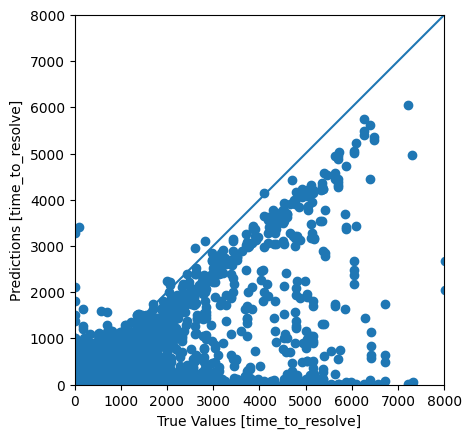

In [150]:
test_pred = modelo.predict(test_X).flatten()

import matplotlib.pyplot as plt

plt.axes(aspect='equal')
plt.scatter(test_y, test_pred)
plt.xlabel('True Values [time_to_resolve]')
plt.ylabel('Predictions [time_to_resolve]')
lims = [0, 8000]
plt.xlim(lims)
plt.ylim(lims)
_=plt.plot(lims, lims)

### Segundo modelo - 4 variables de entrada, 2 capas y 1 salida.

In [152]:
modelo2 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(units=1)   
])

In [161]:
modelo2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [162]:
%%time
history = modelo2.fit(
    train_X,
    train_y,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 2s 412us/step - loss: 181.7839 - val_loss: 176.5278
Epoch 2/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - loss: 179.2073 - val_loss: 170.2352
Epoch 3/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step - loss: 178.9752 - val_loss: 179.1277
Epoch 4/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step - loss: 178.5294 - val_loss: 168.6944
Epoch 5/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step - loss: 178.6139 - val_loss: 168.1809
Epoch 6/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step - loss: 178.3500 - val_loss: 170.1145
Epoch 7/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 398us/step - loss: 179.2227 - val_loss: 173.2672
Epoch 8/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - loss: 178.4579 - val_loss: 170.1949
Epoch 9/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step - loss: 178.8719 - val_loss: 169.5374
Epoch 10/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step - loss: 178.8104 - val_loss: 172.8097
Epoch 11/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 39

In [163]:
test_res = {}
test_res['modelo2'] = modelo2.evaluate(
    test_X,
    test_y, verbose=0)

In [165]:
test_res['modelo2'] = modelo2.evaluate(test_X, test_y, verbose=0)

In [166]:
test_res

{'modelo2': 178.1721649169922}

867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


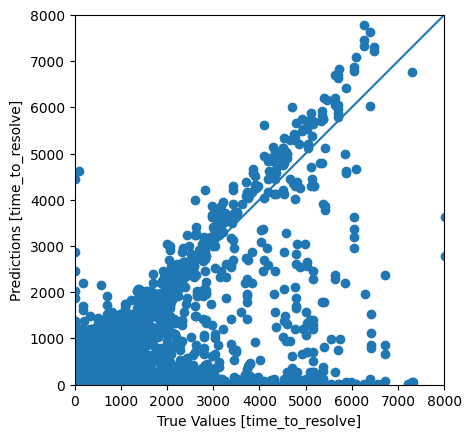

In [167]:
test_pred = modelo2.predict(test_X).flatten()

import matplotlib.pyplot as plt

plt.axes(aspect='equal')
plt.scatter(test_y, test_pred)
plt.xlabel('True Values [time_to_resolve]')
plt.ylabel('Predictions [time_to_resolve]')
lims = [0, 8000]
plt.xlim(lims)
plt.ylim(lims)
_=plt.plot(lims, lims)

### Tercer modelo - 4 variables de entrada, 1 capa con activación RELU y 1 salida.

In [168]:
modelo3 = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(units=1)   
])

In [169]:
modelo3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [170]:
%%time
history = modelo3.fit(
    train_X,
    train_y,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 2s 441us/step - loss: 180.3035 - val_loss: 168.9521
Epoch 2/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step - loss: 177.4178 - val_loss: 168.1777
Epoch 3/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step - loss: 177.3962 - val_loss: 171.5843
Epoch 4/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 382us/step - loss: 177.1093 - val_loss: 167.9215
Epoch 5/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step - loss: 177.0085 - val_loss: 168.1645
Epoch 6/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step - loss: 177.0843 - val_loss: 167.7570
Epoch 7/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step - loss: 177.0100 - val_loss: 167.9520
Epoch 8/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 412us/step - loss: 177.0016 - val_loss: 170.0003
Epoch 9/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step - loss: 177.0908 - val_loss: 167.6696
Epoch 10/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 432us/step - loss: 177.0653 - val_loss: 168.1822
Epoch 11/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 41

In [171]:
test_res = {}
test_res['modelo3'] = modelo3.evaluate(
    test_X,
    test_y, verbose=0)

In [172]:
test_res['modelo3'] = modelo3.evaluate(test_X, test_y, verbose=0)

In [173]:
test_res

{'modelo3': 177.1739501953125}

867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


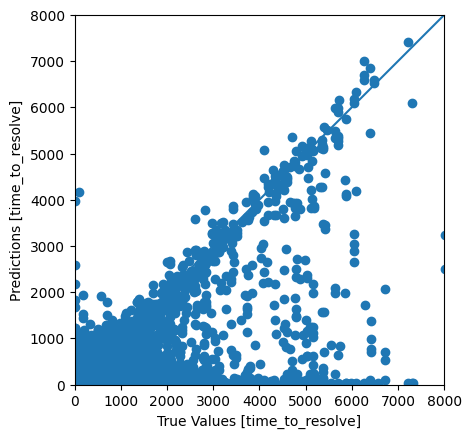

In [174]:
test_pred = modelo3.predict(test_X).flatten()

import matplotlib.pyplot as plt

plt.axes(aspect='equal')
plt.scatter(test_y, test_pred)
plt.xlabel('True Values [time_to_resolve]')
plt.ylabel('Predictions [time_to_resolve]')
lims = [0, 8000]
plt.xlim(lims)
plt.ylim(lims)
_=plt.plot(lims, lims)

### Cuarto modelo - 4 variables de entrada, 1 capa con activación RELU y 1 salida

In [192]:
modelo4 = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(units=1)   
])

In [193]:
modelo4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [194]:
%%time
history = modelo4.fit(
    train_X,
    train_y,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 380us/step - loss: 179.9264 - val_loss: 168.5642
Epoch 2/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step - loss: 177.5785 - val_loss: 169.0978
Epoch 3/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step - loss: 177.3192 - val_loss: 172.7317
Epoch 4/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 370us/step - loss: 177.3373 - val_loss: 168.2623
Epoch 5/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 362us/step - loss: 176.9449 - val_loss: 167.6290
Epoch 6/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - loss: 177.1393 - val_loss: 167.8745
Epoch 7/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step - loss: 176.9417 - val_loss: 168.3204
Epoch 8/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step - loss: 176.7685 - val_loss: 169.0140
Epoch 9/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - loss: 176.9329 - val_loss: 168.4913
Epoch 10/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step - loss: 177.0623 - val_loss: 168.0385
Epoch 11/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 36

In [195]:
test_res = {}
test_res['modelo4'] = modelo4.evaluate(
    test_X,
    test_y, verbose=0)

In [196]:
test_res['modelo4'] = modelo4.evaluate(test_X, test_y, verbose=0)

In [197]:
test_res

{'modelo4': 182.36143493652344}

867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step


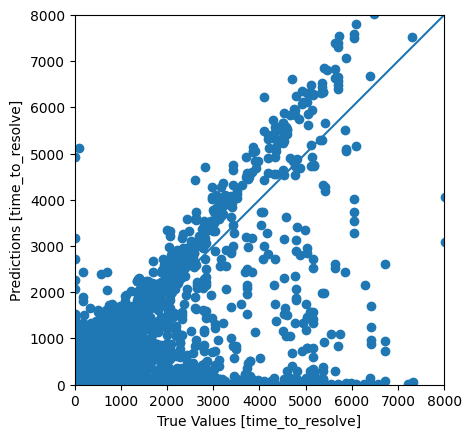

In [198]:
test_pred = modelo4.predict(test_X).flatten()

import matplotlib.pyplot as plt

plt.axes(aspect='equal')
plt.scatter(test_y, test_pred)
plt.xlabel('True Values [time_to_resolve]')
plt.ylabel('Predictions [time_to_resolve]')
lims = [0, 8000]
plt.xlim(lims)
plt.ylim(lims)
_=plt.plot(lims, lims)